In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:

# Fetch environment variables with a fallback to avoid None errors
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")

# Set environment variables
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["LANGSMITH_ENDPOINT"] = LANGSMITH_ENDPOINT
os.environ["LANGSMITH_TRACING"] = LANGSMITH_TRACING


In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-004")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

c:\Users\HP\Desktop\LangGraph\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langgraph.graph import StateGraph,START,END,MessagesState
from typing import TypedDict,Annotated,Literal

In [5]:
def call_model(state:MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [6]:
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot", call_model)
workflow.add_edge(START, "chatbot")  # Define transition from START to "chatbot"
workflow.add_edge("chatbot", END)   # Define transition from "chatbot" to END
app = workflow.compile()


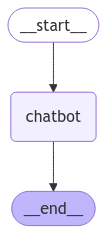

In [7]:
from IPython.display import Image,display


try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [36]:
from langgraph.graph.message import add_messages
class MessagesState(TypedDict):
    messages: Annotated[list,add_messages]

In [8]:
input = {"messages": ["Hi my name is Sparsh Kumar"]}
response = app.invoke(input=input)
print(response)


{'messages': [HumanMessage(content='Hi my name is Sparsh Kumar', additional_kwargs={}, response_metadata={}, id='5436014f-4dda-4dc3-8d9c-5dcfb1baa498'), AIMessage(content='Hello Sparsh Kumar!  Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8eff61fa-3d84-413a-af0f-4de4b8fc8375-0', usage_metadata={'input_tokens': 8, 'output_tokens': 19, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})]}


In [9]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} node")
        print(value)
        print("\n")

Output from chatbot node
{'messages': [AIMessage(content="Hello Sparsh Kumar!  It's nice to meet you.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ac1027d8-7a6a-4642-ad28-de47d3221761-0', usage_metadata={'input_tokens': 8, 'output_tokens': 15, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})]}




In [10]:
from langchain_core.tools import tool
@tool
def search(query:str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny." 
    

In [11]:
tools = [search]

In [12]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools=tools)

In [13]:
llm_with_tools = llm.bind_tools(tools)

In [14]:
def call_model(state:MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages":[response]}

In [15]:
call_model({"messages":["What is Weather in India"]})

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "Weather in India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9ae80b13-ba78-4213-9e44-b8d437a62ffa-0', tool_calls=[{'name': 'search', 'args': {'query': 'Weather in India'}, 'id': 'd83acf3d-0048-4585-b620-2bc370a3c755', 'type': 'tool_call'}], usage_metadata={'input_tokens': 42, 'output_tokens': 5, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}})]}

In [16]:
def router_function(state: MessagesState) -> Literal["tools", "END"]:
    # print(f"here is a state: {state}")
    
    messages = state['messages']  # Extracting the list of messages from the state
    # print(f"here is messages: {messages}")
    
    last_message = messages[-1]  # Get the last message in the list
    # print(f"here is the last message: {last_message}")
    
    # Check if the last message includes a tool call
    if last_message.tool_calls:
        return "tools"  # Route to tools if there is a tool call
    
    return "END"  # End the process if there is no tool call

In [17]:
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools":"tools","END":END})

app = workflow.compile()

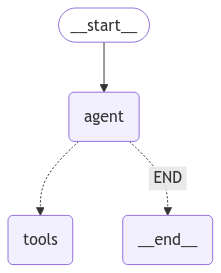

In [18]:
from IPython.display import Image,display


try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [19]:
# call_model({"messages":["How is weather in sf"]})
state = {"messages":["How is weather in sf"]}
app.invoke(state)

{'messages': [HumanMessage(content='How is weather in sf', additional_kwargs={}, response_metadata={}, id='4c06faa5-12f7-4849-817c-91b91c776e75'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4a60d30c-5026-42d9-b5fa-2cf8244cd3ee-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'c3a6a165-7a6b-4bf3-9912-fe9acd3d4a2d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 42, 'output_tokens': 5, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 60 degrees and foggy.", name='search', id='9ea7f492-c46d-4cf8-a817-1a00dc2191d7', tool_call_id='c3a6a165-7a6b-4bf3-9912-fe9acd3d4a2d')]}

In [20]:
call_model({"messages":["Hi, How are You"]})

{'messages': [AIMessage(content="I'm doing well, thank you for asking. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-3e7bede1-e83c-4086-a2c0-dba62d2455f2-0', usage_metadata={'input_tokens': 42, 'output_tokens': 19, 'total_tokens': 61, 'input_token_details': {'cache_read': 0}})]}

In [21]:
workflow.add_edge("tools","agent")


Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [22]:
app = workflow.compile()

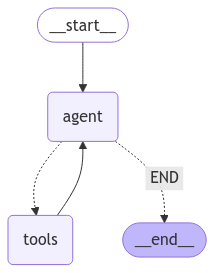

In [23]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [53]:
workflow.edges

{('__start__', 'agent'), ('tools', 'agent')}

In [54]:
state

{'messages': ['How is weather in sf']}

In [24]:
for output in app.stream({'messages': ['How is weather in sf']}):
    for key,value in output.items():
        print(f"From node {key}")
        print(value)
        print("\n")

From node agent
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5860c672-86fa-4c10-8f60-94b808da3fc1-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': '327ec306-1e19-4bfa-9f0b-9cfa06586589', 'type': 'tool_call'}], usage_metadata={'input_tokens': 42, 'output_tokens': 5, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}})]}


From node tools
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='10fdb2df-23d9-4292-9e95-4b2e5b3ea49c', tool_call_id='327ec306-1e19-4bfa-9f0b-9cfa06586589')]}


From node agent
{'messages': [AIMessage(content="It's 60 degrees and foggy.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ra

In [25]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [ ]:
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent",call_model)
workflow3.add_node("tools",tool_node)

workflow.add_conditional_edges("agent",router_function,{"tools":"tools","END":END})